# Calling HMETS on the Raven server

Here we use birdy's WPS client to launch the HMETS hydrological model on the server and analyze the output. 

In [1]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import json
import os

# Set environment variable RAVEN_WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("RAVEN_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
wps = WPSClient(url)

In [2]:
# Get the documentation for the method's usage:
help(wps.regionalisation)

Help on method regionalisation in module birdy.client.base:

regionalisation(ts, latitude, longitude, model_name, properties=None, elevation=None, start_date=datetime.datetime(1, 1, 1, 0, 0), end_date=datetime.datetime(1, 1, 1, 0, 0), name='watershed', ndonors=5, min_nse=0.6, method='SP_IDW', area=0.0) method of birdy.client.base.WPSClient instance
    Compute the hydrograph for an ungauged catchment using a regionalization method.
    
    Parameters
    ----------
    ts : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`text/plain`, :mimetype:`application/x-zipped-shp`
        Files (text or netCDF) storingdaily liquid precipitation (pr), solid precipitation (prsn), minimum temperature (tasmin), maximum temperature (tasmax), potential evapotranspiration (evspsbl) and observed streamflow (qobs [m3/s]).
    start_date : dateTime
        Start date of the simulation (AAAA-MM-DD). Defaults to the start of the forcing file.
    end_date : dateTime
        End date of the simulatio

In [3]:
# Forcing files. This file should only contain weather data (tmin, tmax, rain, snow, pet (if desired), etc. 
# No streamflow is required. This is a link to a string, but you can submit a string to your netcdf file directly.
ts = str(TESTDATA['raven-hmets-nc-ts'])

# Model configuration parameters
config = dict(
    start_date=dt.datetime(2000, 1, 1),
    end_date=dt.datetime(2002, 1, 1),
    area=4250.6,
    name='Saumon',
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    method='PS', # One of the methods described above
    model_name='HMETS', # One of the two models are allowed: HMETS and GR4JCN
    min_nse=0.7, # Minimumcalibration NSE required to be considered a donor (for selecting good donor catchments)
    ndonors=5, # Number of donors we want to use. Usually between 4 and 8 is a robust number.
    properties=json.dumps({'latitude':54.4848, 'longitude':-123.3659, 'forest':0.4}),
    )

# Let's call the model with the timeseries, model parameters and other configuration parameters
resp = wps.regionalisation(ts=ts, **config)

# # Wait for results to come in
# from time import sleep
# sleep(5)

In [4]:
# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally. 
[hydrograph, ensemble] = resp.get(asobj=True)

The `hydrograph` and `ensemble` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [5]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 732, nbasins: 1)>
array([[  0.      ],
       [277.916569],
       [539.369893],
       ...,
       [ 23.369867],
       [ 22.912411],
       [ 22.475852]])
Coordinates:
    basin_name  (nbasins) object ...
  * time        (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2002-01-01
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

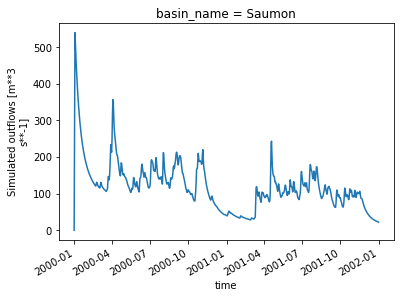

In [6]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

hydrograph.q_sim.plot()

In [7]:
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print("Monthly means: ", hydrograph.q_sim.groupby('time.month').mean())

Max:  <xarray.DataArray 'q_sim' ()>
array(539.369893)
Mean:  <xarray.DataArray 'q_sim' ()>
array(120.044761)
Monthly means:  <xarray.DataArray 'q_sim' (month: 12)>
array([163.591172,  86.604951, 104.529562, 167.926609, 115.902616, 125.099843,
       147.89506 , 134.871203, 127.745297, 110.203753, 109.357798,  45.021447])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12


/home/david/.conda/envs/pavics-sdi/lib/python3.6/site-packages/xarray/core/groupby.py:713: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


Now we can also see the results coming from the 5 donors using the 'ensemble' variable

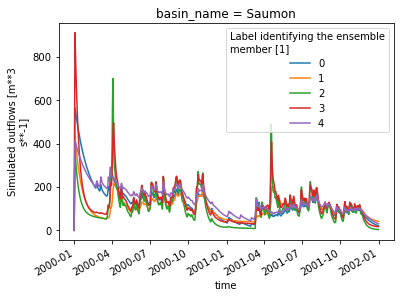

In [8]:
# Plot the simulations from the 5 donor parameter sets
ensemble.q_sim.isel(nbasins=0).plot.line(hue='realization')